In [132]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [121]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [134]:
# Load the data
data = pd.read_csv('results.csv')

# Drop any rows with missing values
# data = data.dropna()

# Separate features (X) and target variable (y)
X = data.drop(columns=['out_of_pocket', 'family_income', 'UID'])
y = np.log(data['out_of_pocket']+1)

label_encoder = LabelEncoder()
X['cancer_type'] = label_encoder.fit_transform(X['cancer_type'])

label_encoder = LabelEncoder()
X['insurance_type'] = label_encoder.fit_transform(X['insurance_type'])

scaler = StandardScaler()
numerical_cols = ['hours_worked', 'age', 'prescription_exp', 'insurance_cover']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
X_train

,insurance_type,race,cancer_dx,hours_worked,employment_status,highest_degree,sex,age,cancer_type,region,prescription_exp,insurance_cover
1639,2,1.0,1.0,0.310507,4.0,7.0,2.0,0.194103,5,1,0.138708,0.469159
2152,6,1.0,1.0,0.310507,4.0,7.0,1.0,0.492703,9,3,-0.113206,-0.233436
1992,2,1.0,1.0,0.310507,4.0,3.0,2.0,0.865952,5,2,0.058745,-0.211939
1248,2,1.0,1.0,0.310507,4.0,4.0,1.0,1.313852,8,2,-0.123597,-0.218275
13,5,1.0,1.0,-0.471406,1.0,6.0,1.0,-1.448196,9,4,-0.075168,0.032700
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2,1.0,1.0,0.310507,4.0,7.0,2.0,1.313852,2,4,0.126219,0.082449
1095,2,1.0,1.0,0.310507,4.0,3.0,1.0,-0.029847,6,1,-0.123416,-0.233306
1130,5,1.0,1.0,0.310507,3.0,4.0,2.0,-0.403097,7,2,-0.058507,0.022162
1294,6,2.0,1.0,0.310507,4.0,3.0,1.0,0.268753,8,2,0.054650,0.155214


In [136]:
# Define models
models = {
    #"RandomForest": RandomForestRegressor(random_state=42, n_estimators=300),
    "Catboost": CatBoostRegressor(random_state=42, n_estimators=300, learning_rate=0.02),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=300, objective='reg:squarederror', learning_rate=0.02),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.02),
}

# Define tolerance for custom accuracy
tolerance = 0.1  # 10% tolerance

# Function to calculate custom accuracy
def custom_accuracy(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) / y_true < tolerance) * 100

# Initialize dictionary to store results
model_scores = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    print(f"{model_name} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    custom_acc = custom_accuracy(y_test, y_pred, tolerance)

    model_scores[model_name] = {"RMSE": rmse, "MAE": mae, "Custom Accuracy (10% tolerance)": custom_acc}
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, Custom Accuracy (10% tolerance): {custom_acc:.2f}%")


0:	learn: 2.3041855	total: 1.36ms	remaining: 406ms
1:	learn: 2.2889337	total: 3.14ms	remaining: 468ms
2:	learn: 2.2754428	total: 4.53ms	remaining: 448ms
3:	learn: 2.2614607	total: 5.83ms	remaining: 432ms
4:	learn: 2.2474558	total: 7.21ms	remaining: 425ms
5:	learn: 2.2348524	total: 8.53ms	remaining: 418ms
6:	learn: 2.2239205	total: 10.2ms	remaining: 427ms
7:	learn: 2.2124050	total: 11.6ms	remaining: 422ms
8:	learn: 2.1999147	total: 12.6ms	remaining: 409ms
9:	learn: 2.1879134	total: 13.9ms	remaining: 404ms
10:	learn: 2.1770527	total: 14.9ms	remaining: 392ms
11:	learn: 2.1656300	total: 16.2ms	remaining: 389ms
12:	learn: 2.1548357	total: 17.5ms	remaining: 387ms
13:	learn: 2.1446672	total: 18.9ms	remaining: 386ms
14:	learn: 2.1347725	total: 20.3ms	remaining: 386ms
15:	learn: 2.1240768	total: 21.7ms	remaining: 385ms
16:	learn: 2.1141222	total: 22.9ms	remaining: 382ms
17:	learn: 2.1032515	total: 24.2ms	remaining: 380ms
18:	learn: 2.0939116	total: 25.6ms	remaining: 379ms
19:	learn: 2.0850291	t


Model Performance Comparison:
               RMSE       MAE  Custom Accuracy (10% tolerance)
Catboost  1.734805  1.306242                        33.187773
XGBoost   1.841485  1.342257                        34.497817
LightGBM  1.789816  1.328215                        32.532751


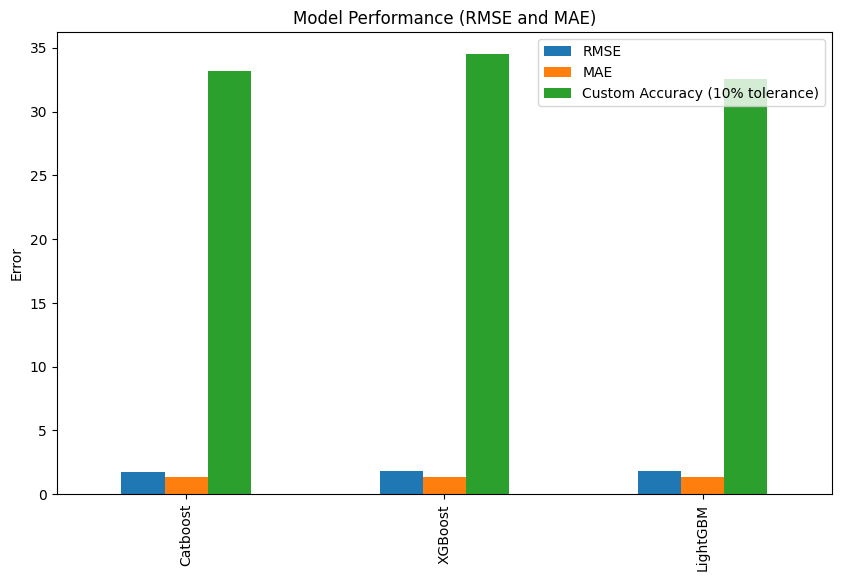

Best model (Catboost) saved as 'Catboost_model.pkl'.


In [137]:
# Display model performance comparison
model_performance = pd.DataFrame(model_scores).T
print("\nModel Performance Comparison:\n", model_performance)

# Optional: Plot model performance
model_performance.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance (RMSE and MAE)")
plt.ylabel("Error")
plt.show()

# Save the best model based on RMSE
best_model_name = model_performance['RMSE'].idxmin()
best_model = models[best_model_name]
pickle.dump(best_model, open(f'{best_model_name}_model.pkl', 'wb'))
print(f"Best model ({best_model_name}) saved as '{best_model_name}_model.pkl'.")

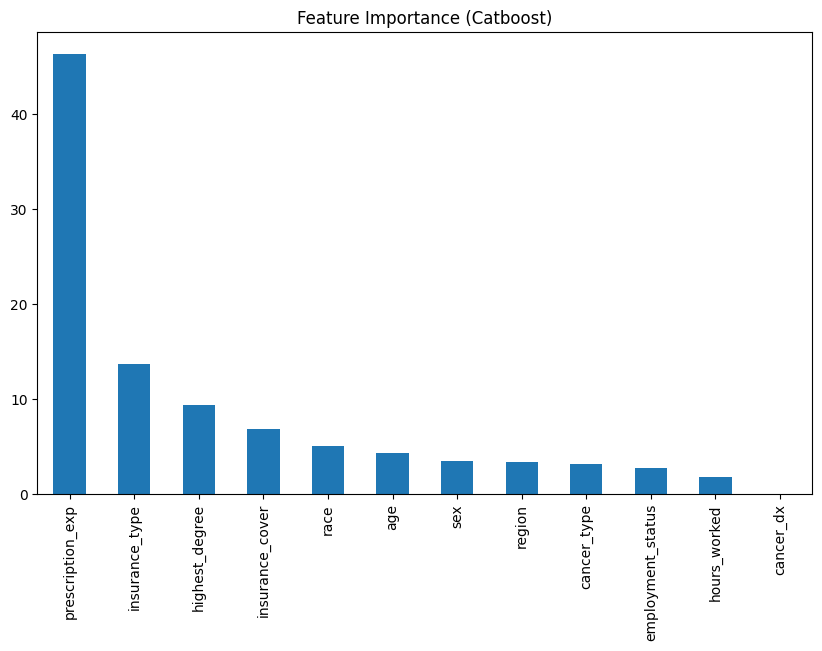

In [138]:
# Check feature importance using Random Forest
feature_importances = models["Catboost"].feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title("Feature Importance (Catboost)")
plt.show()



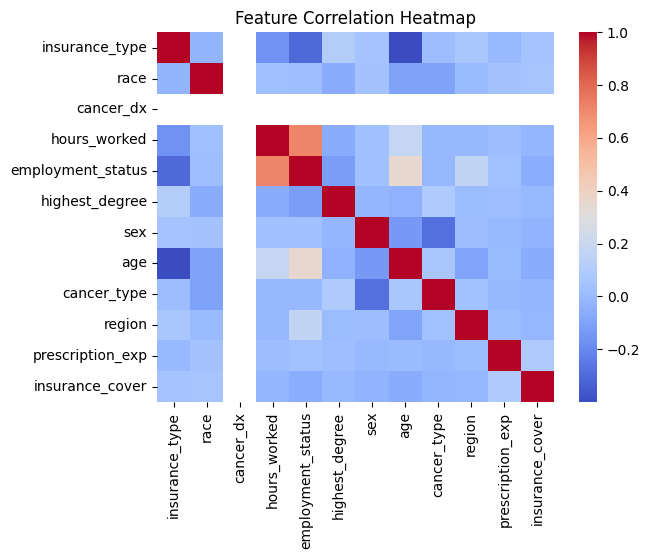

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Check correlations
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()



In [ ]:
# from sklearn.model_selection import train_test_split

# # Split data into train and test sets *before* applying transformations
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Impute missing values using SimpleImputer before applying PolynomialFeatures
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean') # You can choose a different strategy if needed

# # Fit and transform on training data, then transform test data
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# # Initialize and fit GridSearch
# grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,
#                            scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train_poly, y_train)

# # Best parameters
# print("Best Parameters for RandomForest:", grid_search.best_params_)

# # Re-evaluate with best model
# best_rf = grid_search.best_estimator_
# y_pred_rf = best_rf.predict(X_test)
# print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

In [130]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid_lgbm = {
    'n_estimators': [100, 300],      # Fewer boosting rounds to test
    'max_depth': [10, -1],           # Moderate depth and no limit
    'num_leaves': [20, 31],          # Smaller number of leaves
    'learning_rate': [0.01, 0.05],   # Common learning rates
    'subsample': [0.8, 1.0],         # Sample fraction for bagging
    'colsample_bytree': [0.8, 1.0]   # Feature sampling
}

grid_search_lgbm = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

print("Best Parameters for LightGBM:", grid_search_lgbm.best_params_)


KeyboardInterrupt: 

In [140]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

best_params = {
    'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31, 'subsample': 0.8
}

# Initialize LightGBM model with the best parameters
best_lgbm = lgb.LGBMRegressor(**best_params)

# Fit the model to the training data
best_lgbm.fit(X_train, y_train)

# Predict on the test set
y_pred_lgbm = best_lgbm.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print("Tuned RMSE for LightGBM:", rmse)

# Calculate R-squared (R²) for accuracy
r2 = r2_score(y_test, y_pred_lgbm)
print("R-squared for LightGBM:", r2)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 1828, number of used features: 11
[LightGBM] [Info] Start training from score 5.830194
Tuned RMSE for LightGBM: 1.7648560157148714
R-squared for LightGBM: 0.3946396534373322
